In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
from scipy.optimize import curve_fit
import photutils
import time
import datetime as dt
from scipy import fftpack
import nbformat
import plotly.graph_objects as go
from PIL import Image
from turbustat.statistics import PowerSpectrum
from scipy.signal import butter, filtfilt
import ipywidgets as widgets
from IPython.display import display, clear_output
from astropy.io.fits import Header

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [2]:
# File containing the images
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\febbraio\arcturus_633nm_10ms.ome.tif")

immagini = tifffile.imread(file) 

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0109# 0.0377 #0.0244*2 #0.0376*2 #0.0268 marzo #0.0244 febb #0.0376 #

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 633e-9 #700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds, diffraction_limit_arcseconds/plate_scale)
print("Prima :", diffraction_limit_arcseconds/0.0376)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) # corrisponde al diametro del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)



Diffraction limit in arcseconds and pixels:  0.17504418560439558 16.05909959673354
Prima : 4.65543046820201
Check radius in pixels:  16


### Immagine prova

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\buonc\AppData\Local\Temp\ipykernel_21304\1429857575.py:1: SyntaxWarning: invalid escape sequence '\p'
  image = np.asarray(Image.open('immagini\prova_fft.png'))


(1127, 2002)


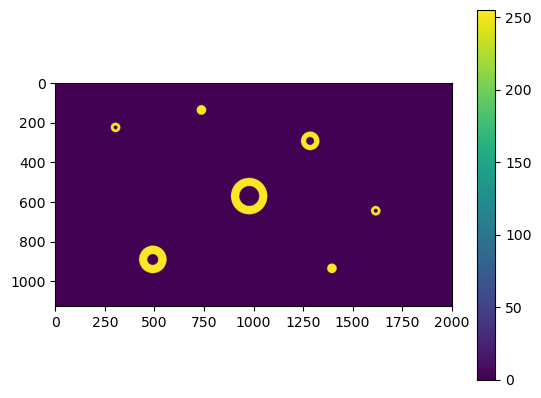

In [4]:
image = np.asarray(Image.open('immagini\prova_fft.png'))
print (image.shape)
imgplot = plt.imshow(image)
plt.colorbar(imgplot, orientation='vertical')

## Power spectrum 1

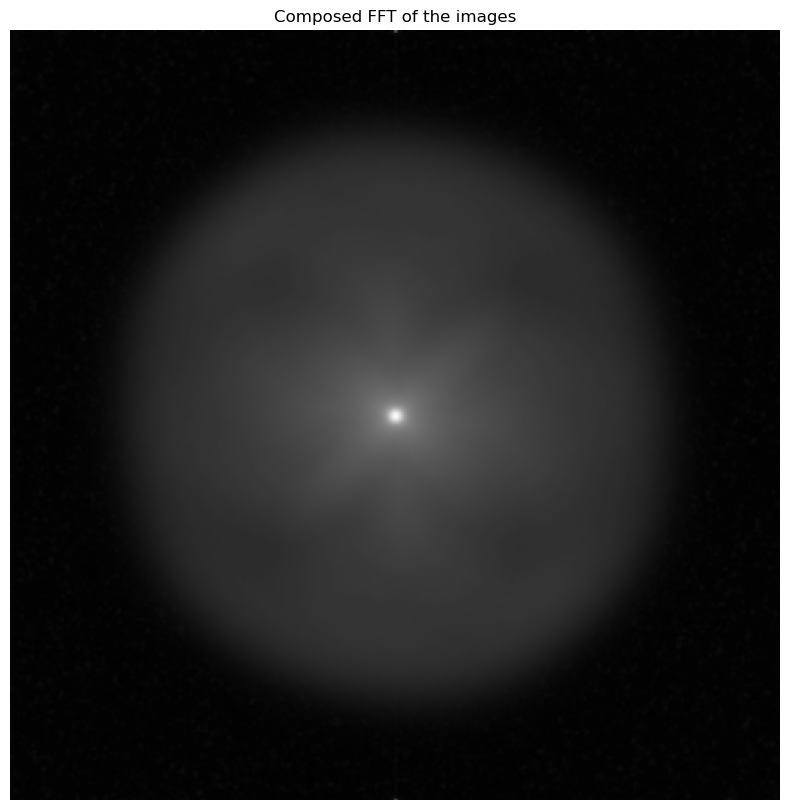

In [20]:
sum_ft = 0

for i in range(4999):
    imagenumber = 0 + i 
    data = immagini[imagenumber]

    data_raw = data.copy()
    data_clean = data_raw.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0

    image = data.copy()
    if image.ndim == 3:
        image = image[:, :, :3].mean(axis=2) 
    elif image.ndim == 2:
        image = image  
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.shape))

    ft = calculate_2dft(image)
    sum_ft += np.abs(ft)


plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(np.log(sum_ft))
plt.axis("off")
plt.title("Composed FFT of the images")
plt.show()

hdu = fits.PrimaryHDU(sum_ft)
hdul = fits.HDUList([hdu])
hdul.writeto('outputs/composed_fft.fits', overwrite=True)


# Butterworth filter 13/05

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


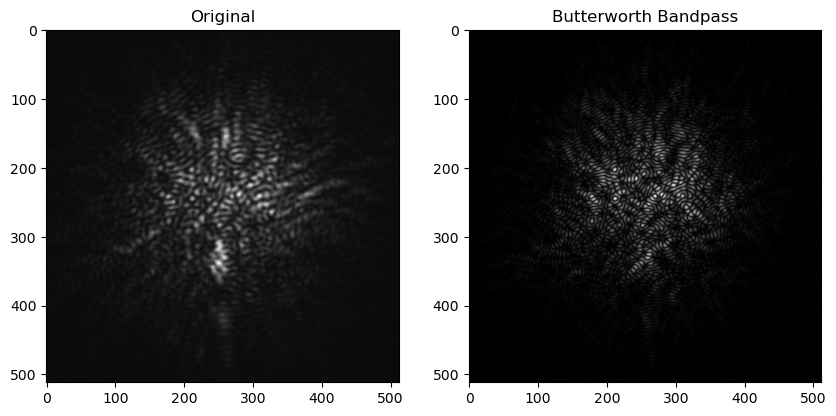

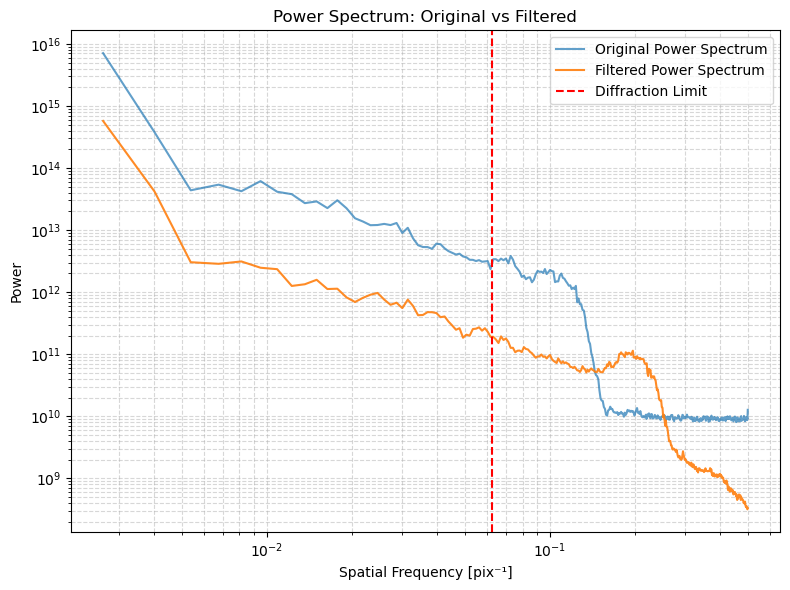

In [40]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

########################################################
########################################################
imagenumber = 1500
image = immagini[imagenumber]
ordine = 10

lowcut_pix = 25#7  #max dimension in pixel
highcut_pix = 15#2.1  #min dimension in pixel

lowcut= 1/lowcut_pix 
highcut = 1/highcut_pix
########################################################
########################################################


def butterworth_bandpass_filter_2d(image, lowcut, highcut, order=ordine, fs=1.0):
    rows, cols = image.shape
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    u = np.linspace(-0.5, 0.5, cols, endpoint=False)
    v = np.linspace(-0.5, 0.5, rows, endpoint=False)
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)

    D0 = (high + low) / 2  # Center frequency
    W = high - low         # Bandwidth

    with np.errstate(divide='ignore', invalid='ignore'):
        H = 1 / (1 + ((D**2 - D0**2) / (D * W + 1e-6))**(2 * order))
        H[D == 0] = 0  # Set center value safely

    return H

def apply_butterworth_bandpass_2d(image, lowcut, highcut, order=ordine, fs=1.0):
    f_transform = fftshift(fft2(image))
    mask = butterworth_bandpass_filter_2d(image, lowcut, highcut, order, fs)
    f_filtered = f_transform * mask
    filtered_image = np.abs(ifft2(ifftshift(f_filtered)))
    return filtered_image


filtered_image = apply_butterworth_bandpass_2d(image, lowcut=lowcut, highcut=highcut, order=ordine)

header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)
pspec_filtered = PowerSpectrum(filtered_image, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Butterworth Bandpass")
plt.imshow(filtered_image, cmap='gray')
plt.show()

plt.figure(figsize=(8, 6))
plt.loglog(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original Power Spectrum', alpha=0.7)
plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Filtered Power Spectrum', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("Power Spectrum: Original vs Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Bandpass scipy.butter

Lowcut and highcut in cycles/pixel:  0.03333333333333333 0.06666666666666667


c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


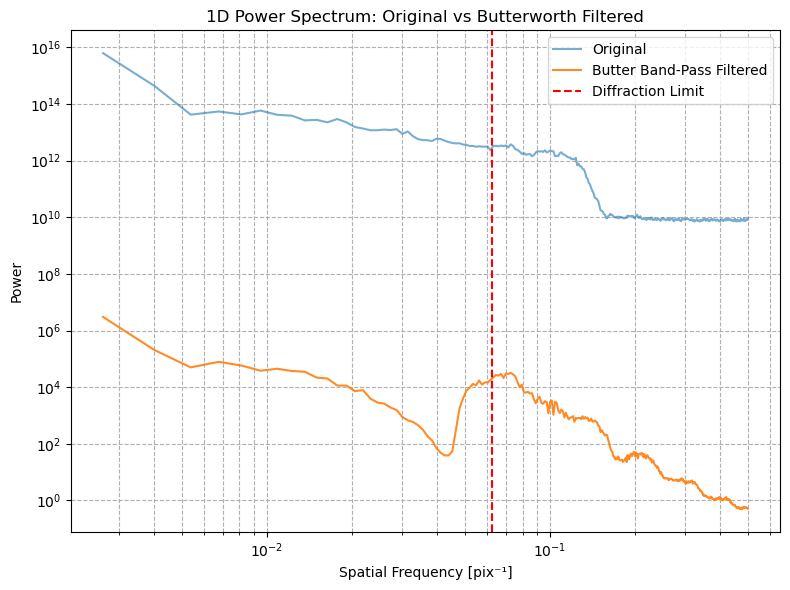

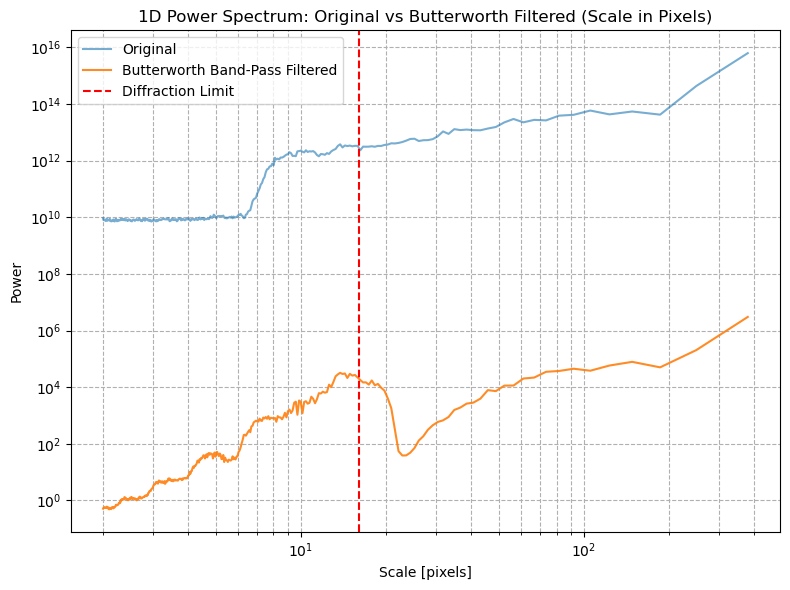

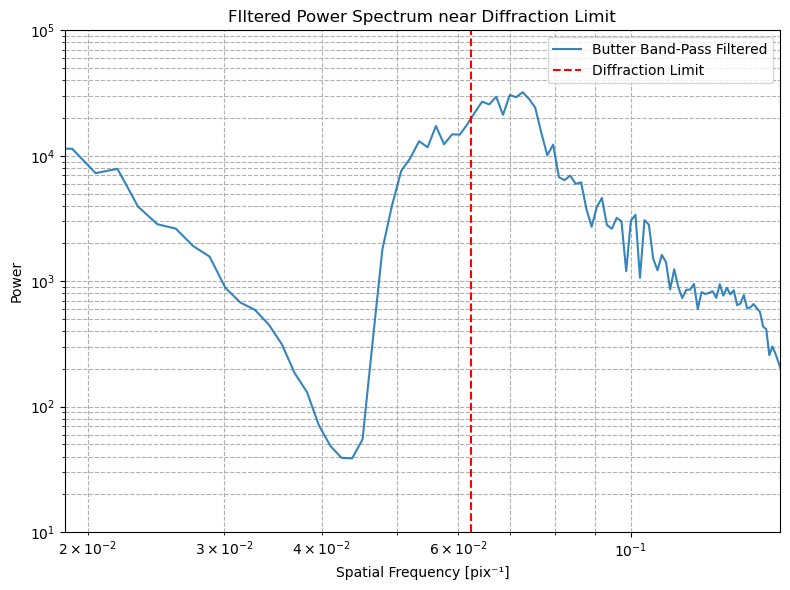

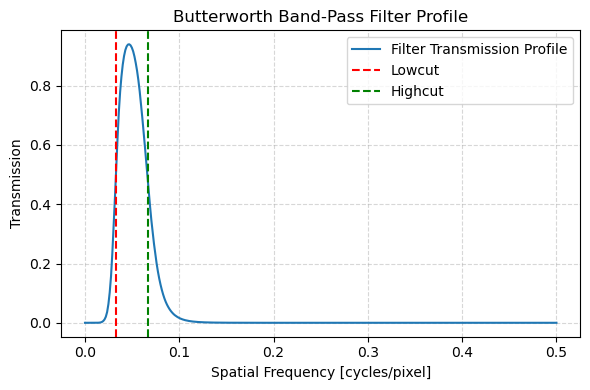

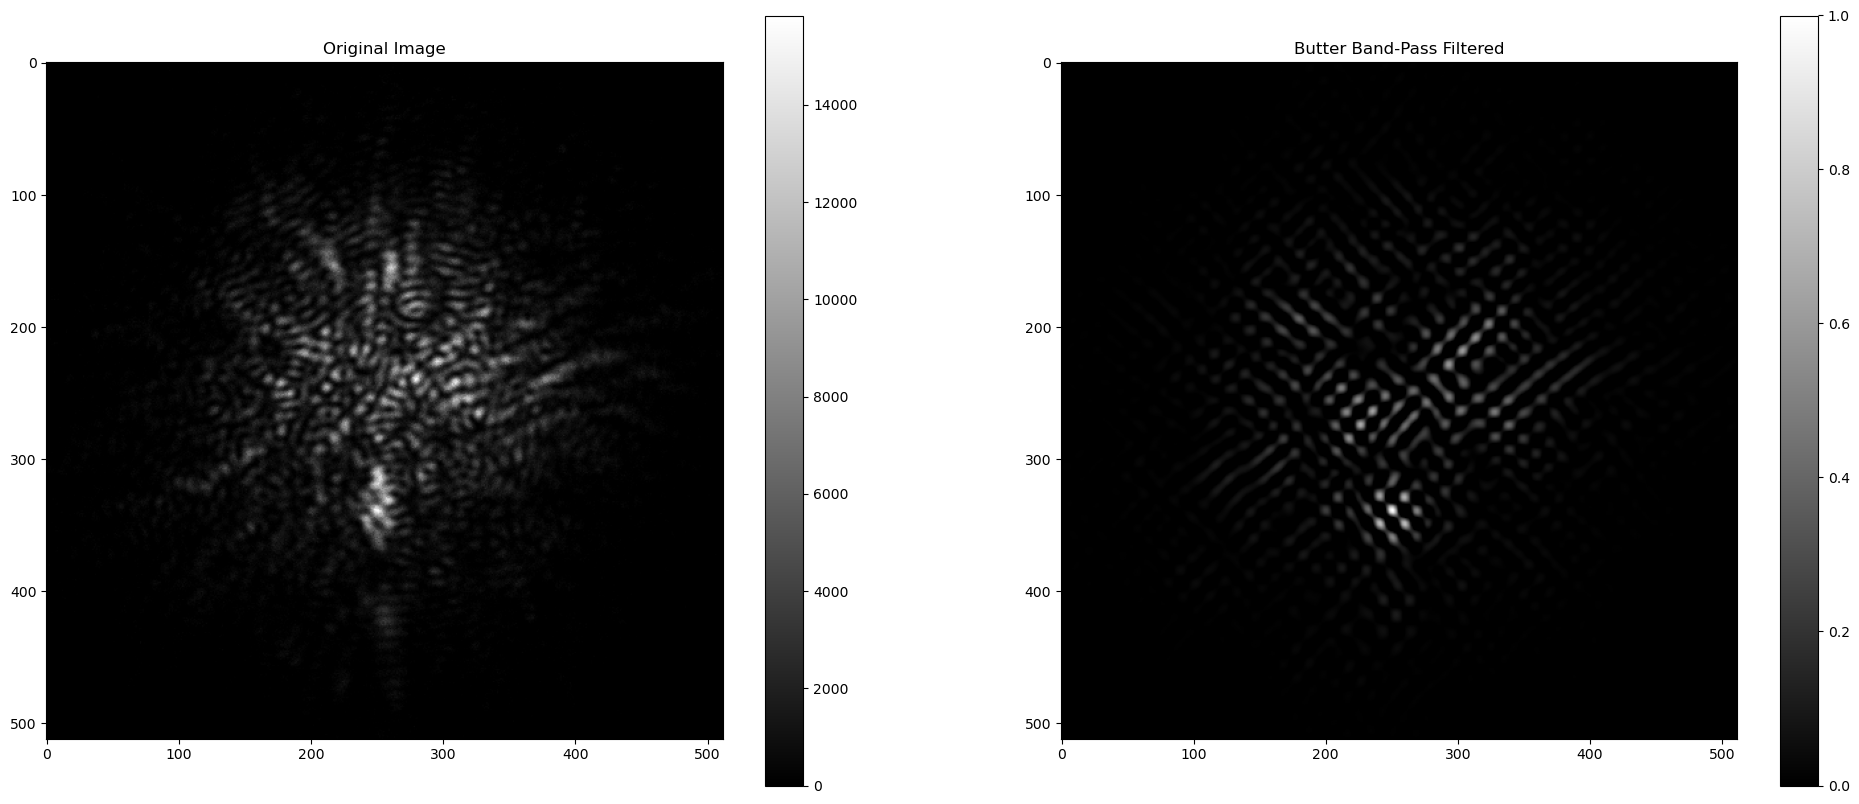

In [ ]:

from scipy.signal import butter, sosfilt, sosfreqz

header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

# pixel_scale = plate_scale  # arcsec/pixel
# header['CDELT1'] = pixel_scale
# header['CDELT2'] = pixel_scale
# header['CUNIT1'] = 'arcsec'
# header['CUNIT2'] = 'arcsec'
# #EXAMPLE: pspec_raw.run(xunit=u.arcsec**-1)

#############################################################
ordine = 5
imagenumber = 1500 #500
stacked = False
lowcut_pix = 30#7  #max dimension in pixel
highcut_pix = 15#2.1  #min dimension in pixel
lowcut= 1/lowcut_pix 
highcut = 1/highcut_pix
########################################################

print("Lowcut and highcut in cycles/pixel: ", lowcut, highcut)
#lowcut = 0.09    # normalized frequency (0 to 1) TOGLIE LE FREQUENZE SOTTO A QUELLA (GRANDI STRUTTURE)
#highcut = 0.25                                   #  TOGLIE LE FREQUENZE SOPRA A QUELLA  (STRUTTURE PICCOLE)
#order = 9
         # QUELLO CHE RIMANE SONO LE FREQUENZE TRA QUELLE DUE (normalizzate con nyquist)
########################################################

def butter_bandpass(lowcut, highcut, fs=1.0, order=ordine):  #fs=1.0
    nyq = 0.5 * fs  
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_2d(image, lowcut, highcut, fs=1.0, order = ordine):  # fs=1.0
    b, a = butter_bandpass(lowcut, highcut, fs, order=ordine) 
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=1, arr=image)   
    filtered = np.apply_along_axis(lambda m: filtfilt(b, a, m, method='gust'), axis=0, arr=filtered)
    return filtered

# def butter_bandpass(lowcut, highcut, fs, order=ordine):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#         return sos

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         sos = butter_bandpass(lowcut, highcut, fs, order=order)
#         y = sosfilt(sos, data)
#         return y

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()


filtered_image = apply_bandpass_2d(image, lowcut, highcut, fs=1.0, order=ordine)

#max_val = np.max(filtered_image)
#filtered_image_normalized = filtered_image / (max_val + 1e-8)
filtered_image = np.nan_to_num(filtered_image, nan=0.0, posinf=0.0, neginf=0.0)
filtered_image[filtered_image < 0] = 0
filtered_image /= (np.max(filtered_image) + 1e-8)


header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)
pspec_filtered = PowerSpectrum(filtered_image, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)


plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.6)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Butter Band-Pass Filtered', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale) , color='r', linestyle='--', label='Diffraction Limit')
#plt.axvline(x=1/(0.209/plate_scale), color='g', linestyle='--', label='Median FWHM of the image')
#plt.axvline(x=1/( 0.209/plate_scale), color='blue', linestyle='--', label='FWHM from Gaussian fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Butterworth Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(1 / pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.6)
plt.plot(1 / pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Butterworth Band-Pass Filtered', alpha=0.9)
plt.axvline(x=diffraction_limit_arcseconds/plate_scale , color='r', linestyle='--', label='Diffraction Limit')
#plt.axvline(x=0.209/plate_scale, color='g', linestyle='--', label='Median FWHM of the image')
#plt.axvline(x= 0.209/plate_scale, color='blue', linestyle='--', label='FWHM from Gaussian fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Scale [pixels]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Butterworth Filtered (Scale in Pixels)")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()


plt.figure(figsize=(8, 6))
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Butter Band-Pass Filtered', alpha=0.9)   #1/pspec_filtered.freqs.value
plt.axvline(x=1/(diffraction_limit_arcseconds / plate_scale), color='r', linestyle='--', label='Diffraction Limit')
#plt.axvline(x=1/(diffraction_limit_arcseconds / plate_scale) *2, color='g', linestyle='--', label='Diffraction Limit shifted')
#plt.axvline(x=0.209 / plate_scale, color='g', linestyle='--', label='Median FWHM of the image')
#plt.axvline(x=0.209 / plate_scale, color='blue', linestyle='--', label='FWHM from Gaussian fit')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1/(diffraction_limit_arcseconds / plate_scale) * 0.3, 1/(diffraction_limit_arcseconds / plate_scale) * 2.5)
#plt.ylim(1e0, 1e3)
plt.ylim(1e1, 1e5)
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("FIltered Power Spectrum near Diffraction Limit" )#(in pixels)")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

def plot_butterworth_bandpass_profile(lowcut, highcut, order, shape=(512, 512)):
    rows, cols = shape
    cy, cx = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    norm_distance = distance / np.max(distance) * 0.5
    hp = 1 / (1 + (lowcut / (norm_distance + 1e-6))**(2 * order))
    lp = 1 / (1 + (norm_distance / (highcut + 1e-6))**(2 * order))
    bandpass_filter = hp * lp
    # Radial profile
    r = distance.astype(int)
    tbin = np.bincount(r.ravel(), bandpass_filter.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / (nr + 1e-10)


    max_freq = 0.5
    freqs = np.linspace(0, max_freq, len(radial_profile))

    plt.figure(figsize=(6, 4))
    plt.plot(freqs, radial_profile, label="Filter Transmission Profile")
    plt.axvline(lowcut, color='r', linestyle='--', label='Lowcut')
    plt.axvline(highcut, color='g', linestyle='--', label='Highcut')
    plt.xlabel("Spatial Frequency [cycles/pixel]")
    plt.ylabel("Transmission")
    plt.title("Butterworth Band-Pass Filter Profile")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_butterworth_bandpass_profile(lowcut, highcut, ordine, shape=image.shape)


plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Butter Band-Pass Filtered")
plt.colorbar()




In [ ]:
from astropy.io import fits

# Save the filtered image to a FITS file
output_path = "outputs/filtered_image_butter.fits"
fits.writeto(output_path, filtered_image, overwrite=True)
print(f"Filtered image saved to {output_path}")

In [82]:

low_limit = 5     # in pixels
high_limit = 7   
low_freq = 1 / high_limit
high_freq = 1 / low_limit


freqs = pspec_filtered.freqs.value
ps1D = pspec_filtered.ps1D

fit_indices = (freqs >= low_freq) & (freqs <= high_freq)
selected_freqs = freqs[fit_indices]
selected_power = ps1D[fit_indices]

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt, _ = curve_fit(gaussian, selected_freqs, selected_power,
                    p0=[max(selected_power), selected_freqs[np.argmax(selected_power)], 1])

peak_position = popt[1]
fwhm = 2.355 * popt[2]

print(f"Peak Position: {peak_position:.5f} pix⁻¹")
print(f"FWHM: {fwhm:.5f} pix⁻¹")


x_fit = np.linspace(min(selected_freqs), max(selected_freqs), 500)
y_fit = gaussian(x_fit, *popt)


plt.figure(figsize=(8, 6))
plt.loglog(freqs, ps1D, '-', label='Filtered Power Spectrum', alpha=0.6)
plt.loglog(x_fit, y_fit, color='orange', linestyle='-', label='Gaussian Fit (in selected range)')
plt.axvline(x=peak_position, color='green', linestyle='-', label=f'Peak: {peak_position:.4f} pix⁻¹')
plt.axvspan(peak_position - fwhm / 2, peak_position + fwhm / 2, color='grey', alpha=0.2, label='FWHM of the fit')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("Filtered Power Spectrum with Gaussian Fit")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


zoom_range = (peak_position - fwhm, peak_position + fwhm)
zoom_indices = (freqs >= zoom_range[0]) & (freqs <= zoom_range[1])
zoom_freqs = freqs[zoom_indices]
zoom_power = ps1D[zoom_indices]

plt.figure(figsize=(8, 6))
plt.loglog(zoom_freqs, zoom_power, '-', label='Filtered Power Spectrum', alpha=0.6)
plt.loglog(x_fit, y_fit, color='orange', linestyle='-', label='Gaussian Fit')
plt.axvline(x=peak_position, color='green', linestyle='-', label=f'Peak: {peak_position:.4f} pix⁻¹')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='red', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Median FWHM from gaussian fit')
plt.axvspan(peak_position - fwhm / 2, peak_position + fwhm / 2, color='grey', alpha=0.2, label='FWHM of the fit')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("Zoomed View of Central Peak with Gaussian Fit")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

# Butterwoth 3

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


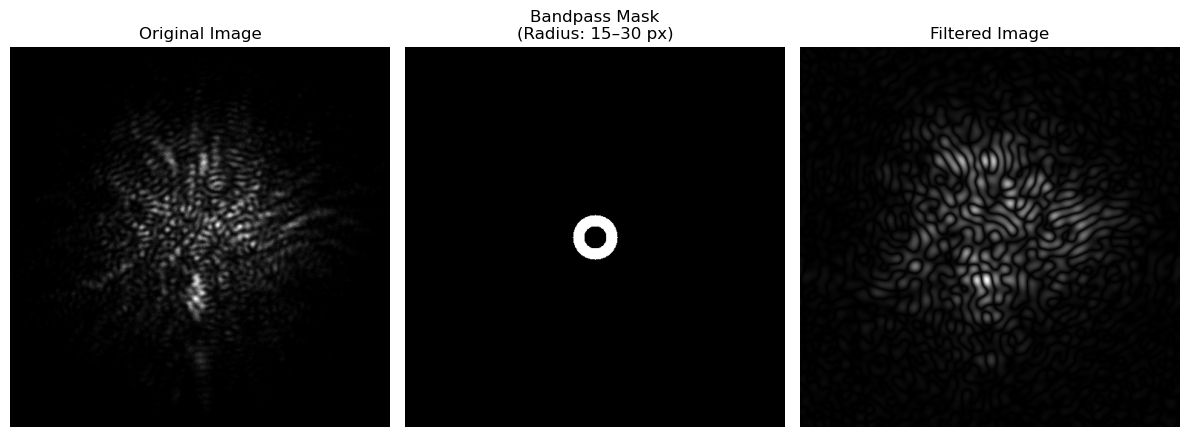

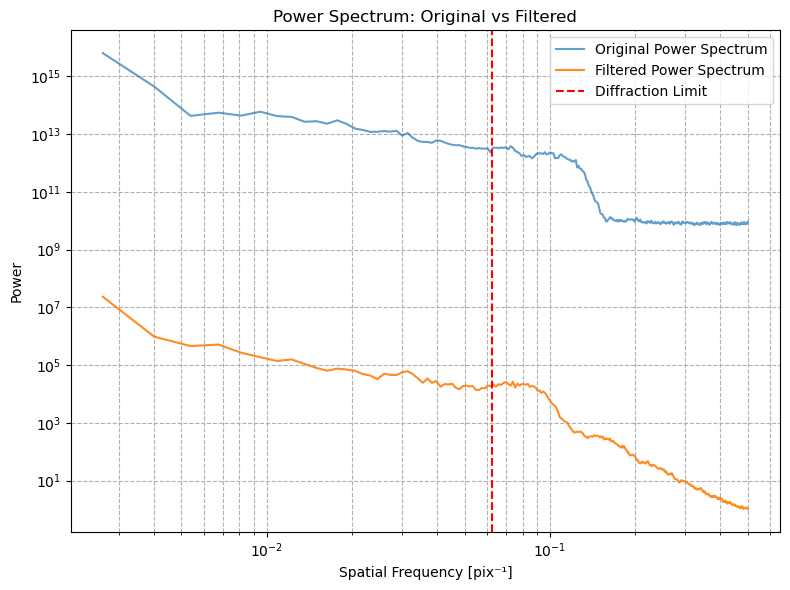

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from turbustat.statistics import PowerSpectrum
from astropy.io.fits import Header
import astropy.units as u

# Select image or stack
imagenumber = 1500
stacked = False

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

# Background subtraction and clipping
background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# FFT Bandpass Filter Function
def fft_bandpass_filter(gray_img, low_radius_px, high_radius_px):
    f = np.fft.fft2(gray_img)
    fshift = np.fft.fftshift(f)

    rows, cols = gray_img.shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    mask = np.logical_and(distance >= low_radius_px, distance <= high_radius_px).astype(np.uint8)

    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back, mask

# Apply manual FFT bandpass filter
low_radius = 15     # in pixels
high_radius = 30    # in pixels
filtered_image, mask = fft_bandpass_filter(image, low_radius, high_radius)

# Normalize and clean
filtered_image = np.nan_to_num(filtered_image, nan=0.0, posinf=0.0, neginf=0.0)
filtered_image[filtered_image < 0] = 0
filtered_image /= (np.max(filtered_image) + 1e-8)

# Power Spectrum Analysis
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(filtered_image, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# Plot original, mask, filtered
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(mask, cmap='gray'), plt.title('Bandpass Mask\n(Radius: {}–{} px)'.format(low_radius, high_radius)), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(filtered_image, cmap='gray'), plt.title('Filtered Image'), plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original Power Spectrum', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label='Filtered Power Spectrum', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("Power Spectrum: Original vs Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


# Bandpass con CV2

Lowcut frequency: 0.038461538461538464 1/pix → Radius: 19 px
Highcut frequency: 0.08333333333333333 1/pix → Radius: 42 px


c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nan

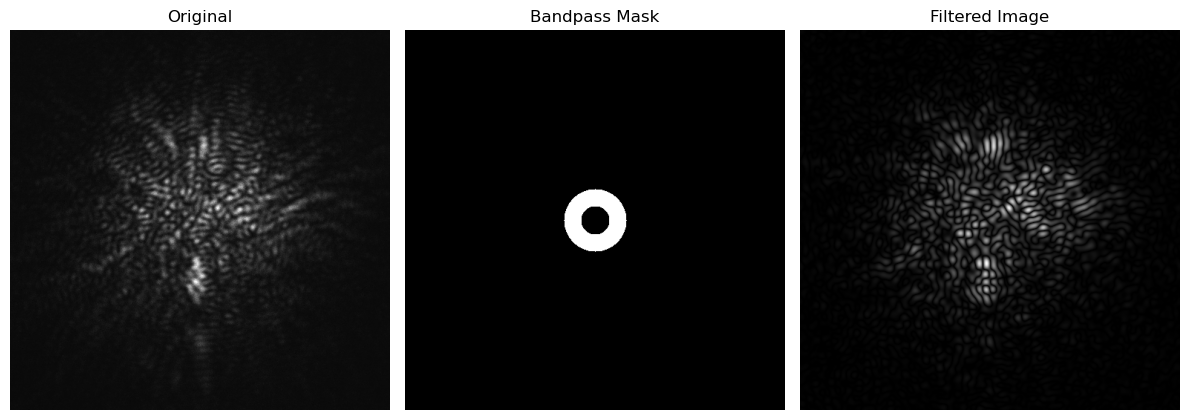

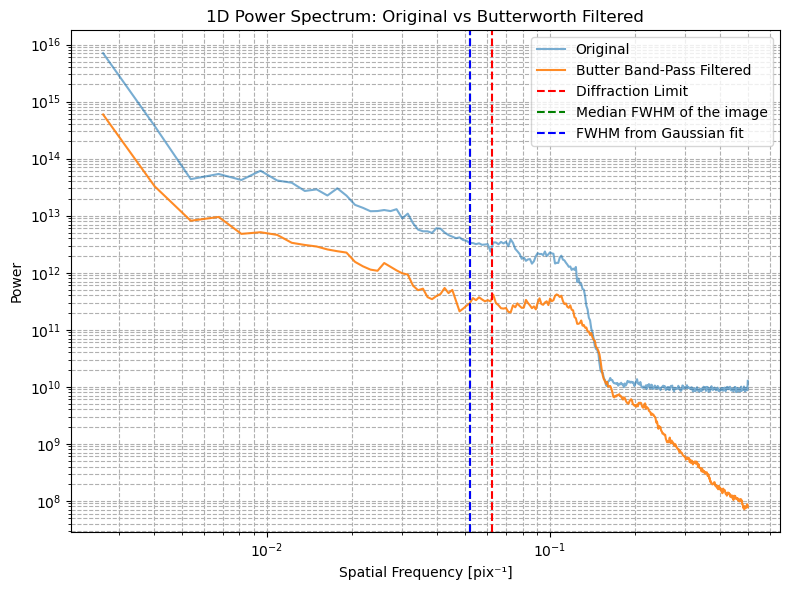

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


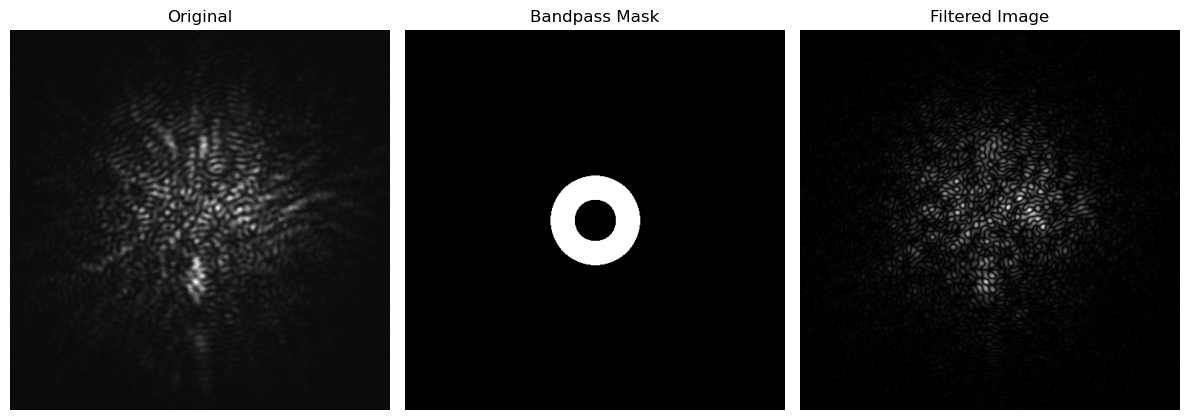

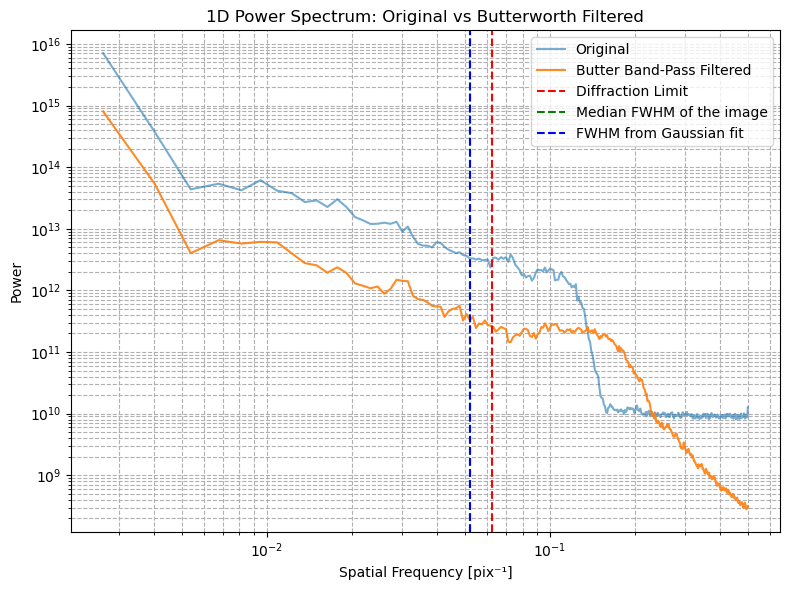

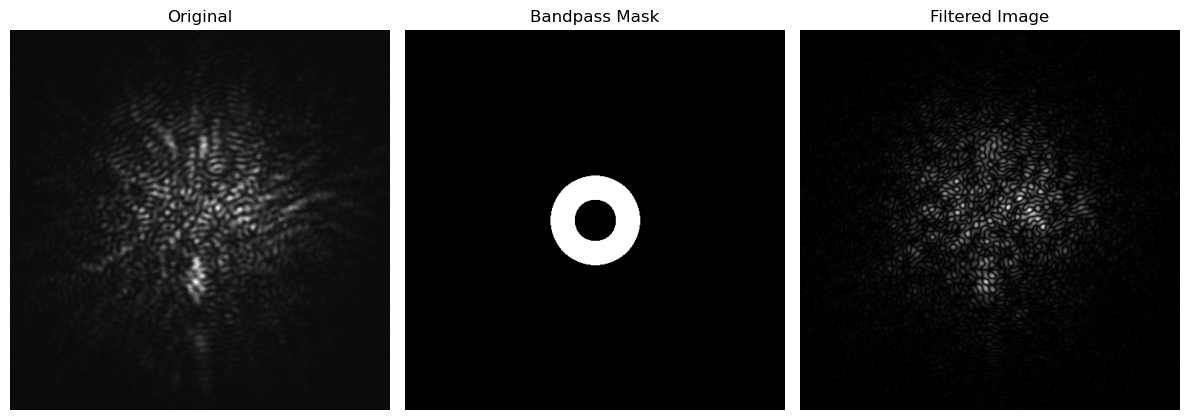

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagenumber = 1500

import numpy as np
import cv2
import matplotlib.pyplot as plt

def bandpass_filter(gray_img, low_radius, high_radius):
    # FFT of the image
    f = np.fft.fft2(gray_img)
    fshift = np.fft.fftshift(f)

    # Create bandpass mask
    rows, cols = gray_img.shape
    crow, ccol = rows // 2 , cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    mask = np.logical_and(distance >= low_radius, distance <= high_radius).astype(np.uint8)

    # Apply mask and inverse FFT
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back, mask

img = immagini[imagenumber]

# Define desired bandpass frequency range in units of 1/pixel
lowcut_pix = 26
highcut_pix = 12
lowcut_freq = 1/lowcut_pix  
highcut_freq = 1/highcut_pix  

rows, cols = image.shape
N = (rows + cols) / 2  

low_radius = int(lowcut_freq * N)
high_radius = int(highcut_freq * N)

print(f"Lowcut frequency: {lowcut_freq} 1/pix → Radius: {low_radius} px")
print(f"Highcut frequency: {highcut_freq} 1/pix → Radius: {high_radius} px")

# Apply FFT bandpass filter with converted radii
filtered_image, mask = fft_bandpass_filter(image, low_radius, high_radius)
filtered_img, mask = bandpass_filter(img, low_radius=low_radius, high_radius=high_radius)

# Compute power spectra for the filtered image
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_filtered_img = PowerSpectrum(filtered_img, header=header, distance=1 * u.pc)
pspec_filtered_img.run(verbose=False, xunit=u.pix**-1)

pspec_original_img = PowerSpectrum(img, header=header, distance=1 * u.pc)
pspec_original_img.run(verbose=False, xunit=u.pix**-1)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(mask, cmap='gray'), plt.title('Bandpass Mask'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(filtered_img, cmap='gray'), plt.title('Filtered Image'), plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(pspec_original_img.freqs.value, pspec_original_img.ps1D, label='Original', alpha=0.6)
plt.plot(pspec_filtered_img.freqs.value, pspec_filtered_img.ps1D, label='Butter Band-Pass Filtered', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale) , color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.209/plate_scale), color='g', linestyle='--', label='Median FWHM of the image')
plt.axvline(x=1/( 0.209/plate_scale), color='blue', linestyle='--', label='FWHM from Gaussian fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Butterworth Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

import numpy as np

def fft_bandpass_filter(image, size_min_pix, size_max_pix):
    """
    Applies a sharp FFT bandpass filter to an image.

    Parameters:
    - image (2D array): Input grayscale image.
    - size_min_pix (float): Minimum structure size (in pixels) to retain.
    - size_max_pix (float): Maximum structure size (in pixels) to retain.

    Returns:
    - filtered (2D array): Filtered image (real values).
    - mask (2D array): Binary mask used in frequency domain.
    """

    # FFT of the image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Image dimensions
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # Compute frequency cutoffs in cycles/pixel
    freq_min = 1 / size_max_pix  # low frequency cutoff
    freq_max = 1 / size_min_pix  # high frequency cutoff

    # Convert to radius in pixels using diagonal for correct scaling
    diagonal = np.sqrt(rows**2 + cols**2)
    radius_min = freq_min * diagonal
    radius_max = freq_max * diagonal

    # Create circular bandpass mask
    Y, X = np.ogrid[:rows, :cols]
    distance = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    mask = np.logical_and(distance >= radius_min, distance <= radius_max).astype(np.uint8)

    # Apply mask
    fshift_filtered = fshift * mask

    # Inverse FFT
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back, mask

img = immagini[imagenumber]

# Retain structures between 12 and 26 pixels
filtered_img, mask = fft_bandpass_filter(img, size_min_pix=12, size_max_pix=26)

pspec_filtered_img = PowerSpectrum(filtered_img, header=header, distance=1 * u.pc)
pspec_filtered_img.run(verbose=False, xunit=u.pix**-1)

pspec_original_img = PowerSpectrum(img, header=header, distance=1 * u.pc)
pspec_original_img.run(verbose=False, xunit=u.pix**-1)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(mask, cmap='gray'), plt.title('Bandpass Mask'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(filtered_img, cmap='gray'), plt.title('Filtered Image'), plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(pspec_original_img.freqs.value, pspec_original_img.ps1D, label='Original', alpha=0.6)
plt.plot(pspec_filtered_img.freqs.value, pspec_filtered_img.ps1D, label='Butter Band-Pass Filtered', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale) , color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.209/plate_scale), color='g', linestyle='--', label='Median FWHM of the image')
plt.axvline(x=1/( 0.209/plate_scale), color='blue', linestyle='--', label='FWHM from Gaussian fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Butterworth Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# Show result
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Bandpass Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_img, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')
plt.tight_layout()
plt.show()


# <span style="color:red; font-size: 1em;">################################################################################################################ PARTI INUTILIZZATE #######################################################################################################</span>

# Butterwort 1

In [71]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt

# --------------------------------------------
# Butterworth High-Pass Filter
def butterworth_highpass_filter(image, cutoff, order):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - ccol)**2 + (y - crow)**2)

    # Butterworth high-pass mask
    butterworth_hp = 1 / (1 + (cutoff / (distance + 1e-6))**(2 * order))  # Avoid div by zero

    F_image = fft2(image)
    F_filtered = F_image * fftshift(butterworth_hp)
    filtered_image = np.real(ifft2(F_filtered))

    return filtered_image, butterworth_hp

# --------------------------------------------
imagenumber = 500
stacked = False  # Set to True to stack images

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# --------------------------------------------
# Apply Butterworth High-Pass Filter
cutoff = 10    # Radius in pixels
order = 9      # Filter sharpness (higher = steeper transition)
highpass, hp_filter = butterworth_highpass_filter(image, cutoff=cutoff, order=order)

# Clean filtered image
highpass = np.nan_to_num(np.maximum(highpass, 0))

# --------------------------------------------
# Power Spectrum Calculation
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot Power Spectra
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'Butterworth High-Pass (cutoff={cutoff}, order={order})', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# --------------------------------------------
# Plot Filter
plt.figure(figsize=(6, 5))
plt.imshow(hp_filter, cmap='gray')
plt.title("Butterworth High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2D Fourier Transform Plot
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)
    F_image_shifted = fftshift(F_image)
    magnitude = np.abs(F_image_shifted)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D FFT")
plot_fourier_transform(highpass, title="High-Pass Filtered Image: 2D FFT")

#output_path = "outputs/highpass_filtered_image_Butterworth_filter.fits"
#fits.writeto(output_path, highpass, overwrite=True)
#print(f"Highpass filtered image saved to {output_path}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=custom_cmap)
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(highpass, cmap=custom_cmap)
plt.title("Filtered Image")
plt.colorbar()
plt.tight_layout()
plt.show()

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

# Passband

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


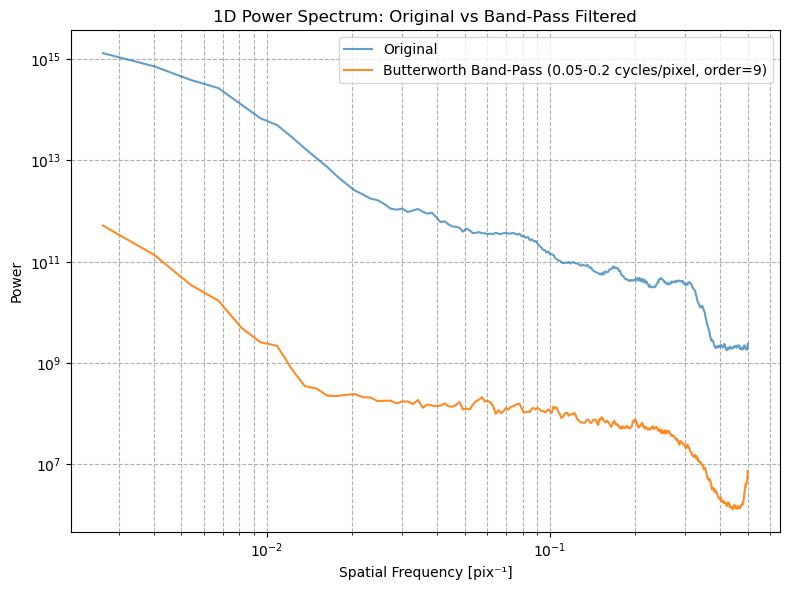

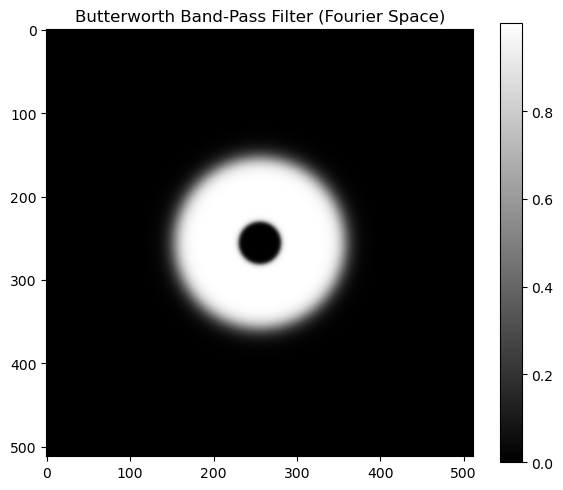

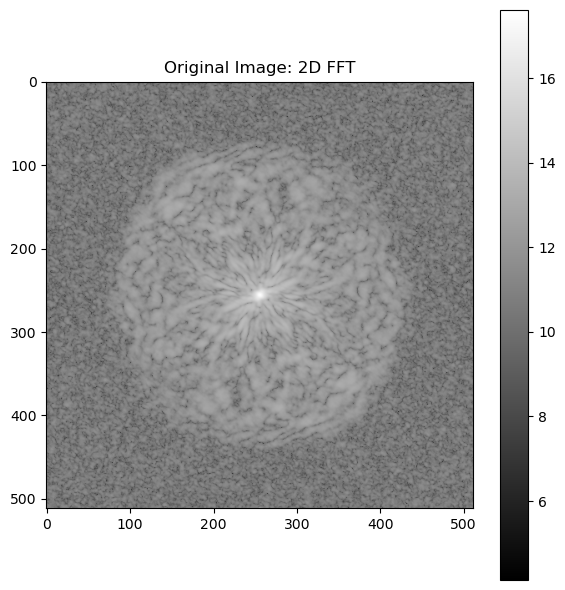

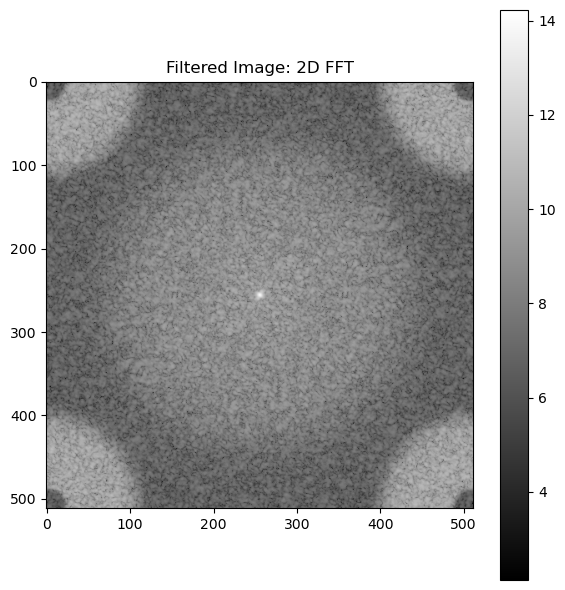

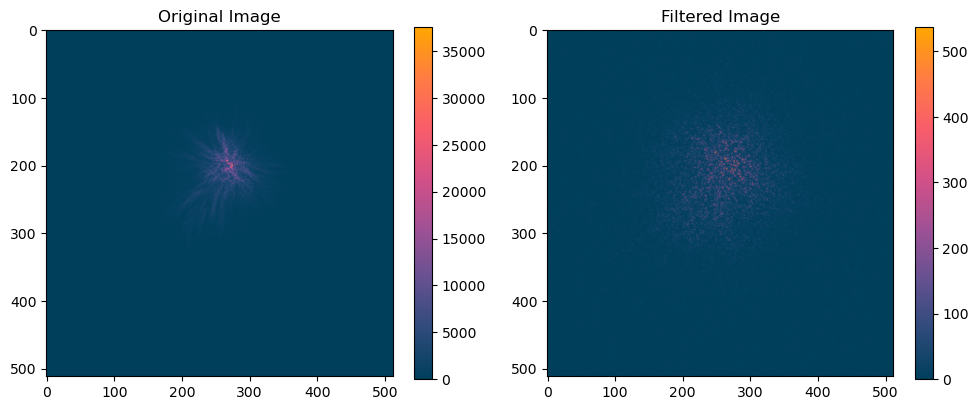

In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt


# ---------------------------------------------------
def butterworth_bandpass_filter(image, lowcut, highcut, order):
    """
    Apply a 2D Butterworth bandpass filter in Fourier space.

    Parameters:
        image : 2D numpy array
        lowcut : float (in cycles/pixel, 0 < lowcut < highcut < 0.5)
        highcut : float
        order : int

    Returns:
        filtered_image : 2D array
        bandpass_mask : 2D filter mask in Fourier domain
    """
    rows, cols = image.shape
    fx = np.fft.fftfreq(cols)
    fy = np.fft.fftfreq(rows)
    fx, fy = np.meshgrid(fx, fy)
    freq_radius = np.sqrt(fx**2 + fy**2)

    # Create Butterworth masks
    hp = 1 / (1 + (lowcut / (freq_radius + 1e-10))**(2 * order))
    lp = 1 / (1 + (freq_radius / (highcut + 1e-10))**(2 * order))
    bandpass_mask = hp * lp

    # Apply filter
    F_image = fft2(image)
    F_filtered = fftshift(bandpass_mask) * F_image
    filtered_image = np.real(ifft2(F_filtered))
    return filtered_image, fftshift(bandpass_mask)

# ---------------------------------------------
# Setup image
imagenumber = 500
stacked = False

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# ---------------------------------------------
# Filter parameters (spatial frequency units: 0.0 to 0.5)
lowcut = 0.05    # Removes frequencies lower than this (large features)
highcut = 0.20   # Removes frequencies higher than this (small features)
order = 9

filtered, filter_mask = butterworth_bandpass_filter(image, lowcut, highcut, order)
filtered = np.nan_to_num(np.maximum(filtered, 0))

# ---------------------------------------------
# Power Spectrum
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(filtered, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# ---------------------------------------------
# Power spectrum plot
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, 
         label=f'Butterworth Band-Pass ({lowcut}-{highcut} cycles/pixel, order={order})', alpha=0.9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs Band-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# ---------------------------------------------
# Filter mask
plt.figure(figsize=(6, 5))
plt.imshow(filter_mask, cmap='gray')
plt.title("Butterworth Band-Pass Filter (Fourier Space)")
plt.colorbar()
plt.tight_layout()
plt.show()

# ---------------------------------------------
def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image)
    magnitude = np.abs(fftshift(F_image))
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, "Original Image: 2D FFT")
plot_fourier_transform(filtered, "Filtered Image: 2D FFT")

# ---------------------------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=custom_cmap)
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(filtered, cmap=custom_cmap)
plt.title("Filtered Image")
plt.colorbar()
plt.tight_layout()
plt.show()


## Power spectrum

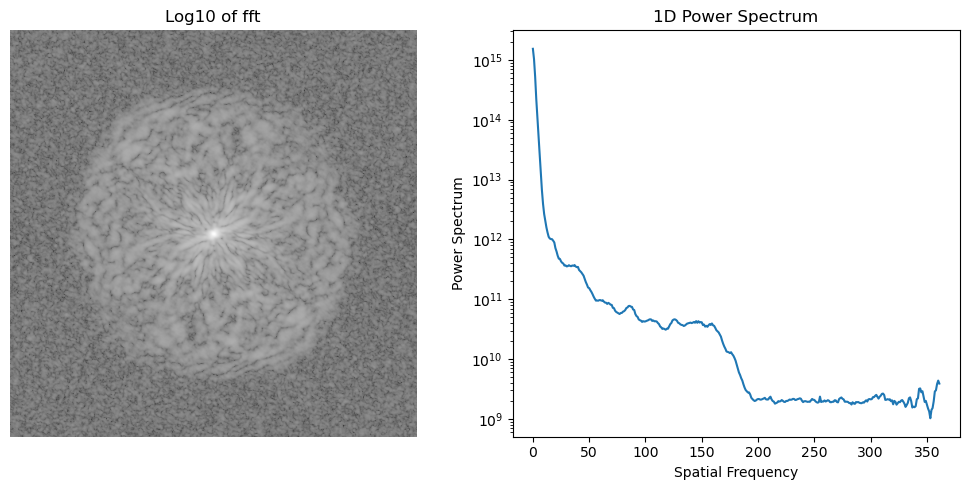

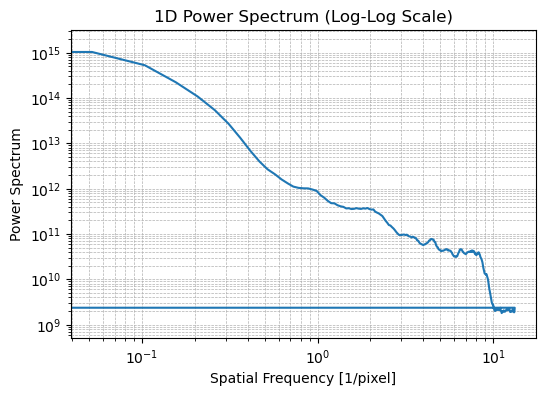

In [ ]:


imagenumber = 500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()
#image = image[:1022, :1022]
# Define a function for azimuthal averaging
def azimuthalAverage(image, center=None):
	"""
	Calculate the azimuthally averaged radial profile.

	Parameters:
	-----------
	image : 2D numpy array
		The 2D image
	center : tuple of int, optional
		The (x, y) pixel coordinates used as the center. If None, the center of the image is used.

	Returns:
	--------
	radial_prof : 1D numpy array
		The azimuthally averaged radial profile
	"""
	y, x = np.indices(image.shape)
	if center is None:
		center = (x.max() / 2, y.max() / 2)

	r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
	r = r.astype(int)

	tbin = np.bincount(r.ravel(), image.ravel())
	nr = np.bincount(r.ravel())
	radial_prof = tbin / nr
	return radial_prof

# Use the azimuthalAverage function instead of radialProfile.azimuthalAverage

F1 = fftpack.fft2(image)
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift( F1 )

# 2D power spectrum
psd2D = np.abs( F2 )**2

#azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(psd2D)

# Plot the 2D power spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(psd2D), cmap='gray')
plt.title("Log10 of fft")
plt.axis("off")

# Plot the azimuthally averaged 1D power spectrum
plt.subplot(1, 2, 2)
plt.semilogy(psd1D)
plt.title("1D Power Spectrum")
plt.xlabel("Spatial Frequency")
plt.ylabel("Power Spectrum")

plt.tight_layout()
plt.show()

# Convert spatial frequency to arcseconds^-1
pixel_scale = plate_scale  # Plate scale in arcseconds/pixel
spatial_frequency = np.fft.fftfreq(image.shape[0], d=pixel_scale)

# Plot the azimuthally averaged 1D power spectrum in log-log scale with correct units
plt.figure(figsize=(6, 4))
plt.loglog(spatial_frequency[:len(psd1D)], psd1D)
plt.title("1D Power Spectrum (Log-Log Scale)")
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power Spectrum")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Turbustat

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning:

Header missing beam information.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_pspec2.py:483: UserWarning:

The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:253: RuntimeWarning:

divide by zero encountered in log10



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2481.
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.42e-163
Time:                        12:10:20   Log-Likelihood:                -60.292
No. Observations:                 362   AIC:                             124.6
Df Residuals:                     360   BIC:                             132.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8241      0.038    233.711      0.0

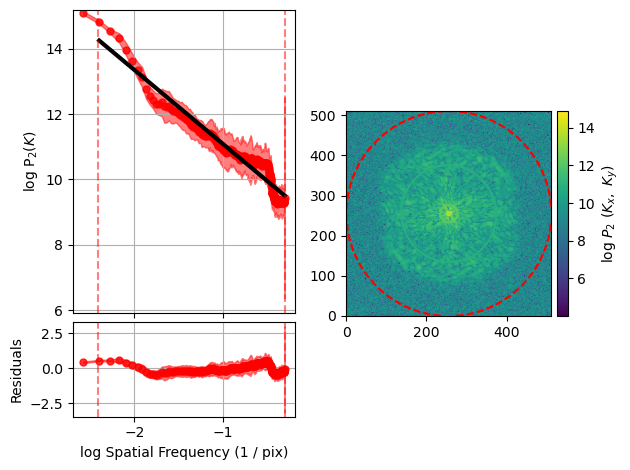

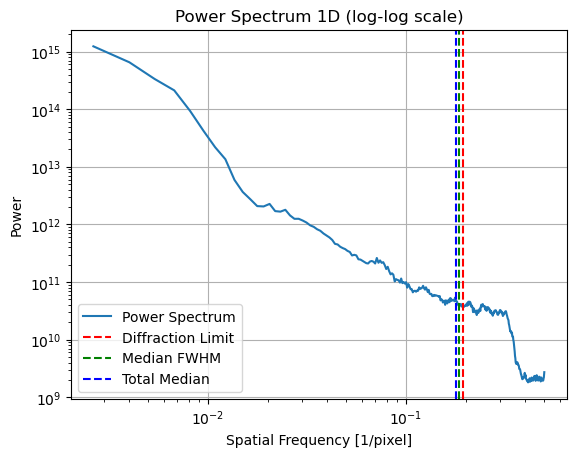

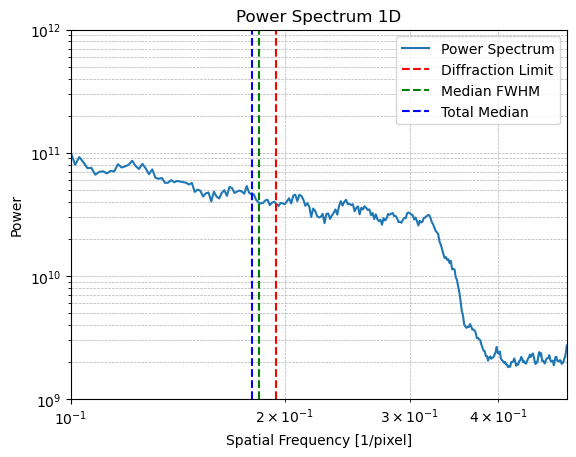

In [ ]:


from astropy.io.fits import Header
from scipy.signal import find_peaks

#################################################################################
imagenumber = 1500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0
image = data.copy()
#############################################################


#SE è DATACUBE ALLORA SI FA image = image [0,:,:] dove il numero selezione l'immagine del cubo
#image = fits.getdata('outputs/composed_fft.fits') #image[0,:,:] #image[0,:,:] #image[imagenumber,:,:] #image[0,:,:]
header = Header()
header['CDELT1'] = 1.0 # scala dei pixel lungo l'asse X (in pixel se si mette la plate scale allora è in arcsec)
header['CDELT2'] = 1.0  # scala dei pixel lungo l'asse Y


# Usa distanza fittizia 
pspec = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec.run(verbose=True, xunit=u.pix**-1)#, low_cut=0.1, high_cut=0.01) 

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec.freqs.value.max())
plt.xlim(0.1, pspec.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pspec.freqs.value,
    y=pspec.ps1D,
    mode='lines',
    name='Power Spectrum'
))

fig.update_layout(
    title="Power Spectrum 1D (Interactive)",
    xaxis_title="Frequenza spaziale [1/pixel]",
    yaxis_title="Potenza",
    xaxis_type="log",
    yaxis_type="log",
    template="plotly_white",
    showlegend=True
)
fig.show()


# frequenze = pspec.freqs        # in unità di 1/pixel
# potenza = pspec.ps1D           # spettro radiale
# pendenza = pspec.slope         # pendenza del fit
# print(f"Frequenze: {frequenze}")
# print(f"Potenza: {potenza}")
# print(f"Pendenza: {pendenza}")


## Passband

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


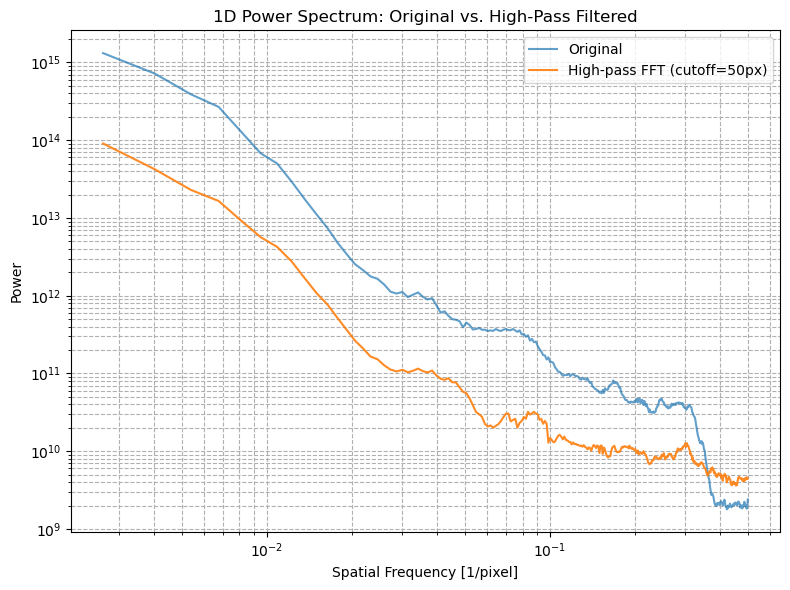

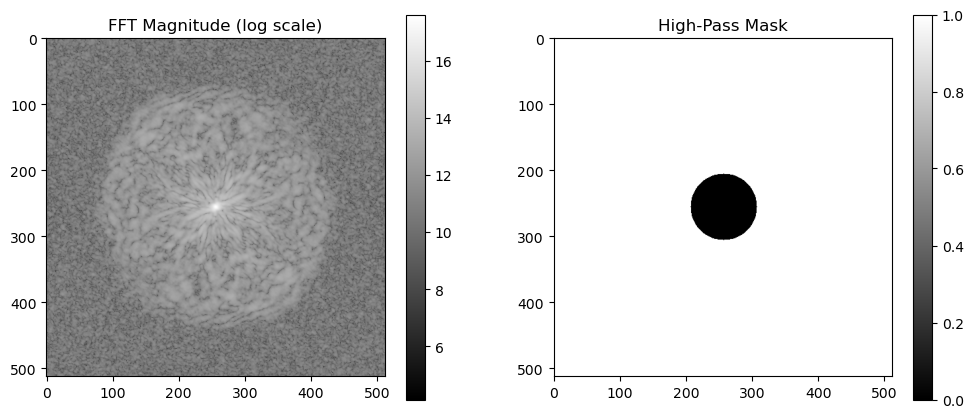

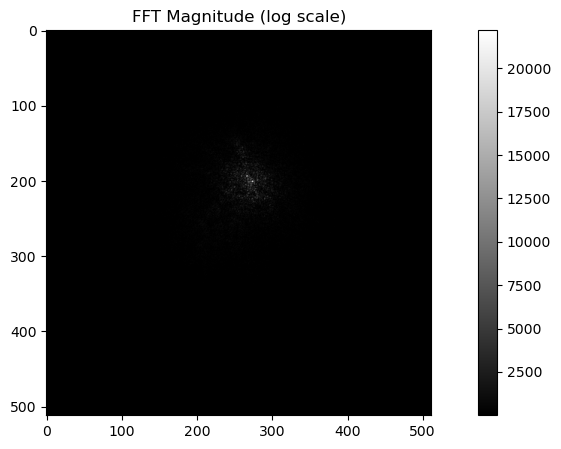

In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
import matplotlib.pyplot as plt


def high_pass_filter_fft(img, cutoff):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    #circular mask
    mask = np.ones((rows, cols), dtype=np.float32)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol)**2 + (y - crow)**2 <= cutoff**2
    mask[mask_area] = 0

    #Apply mask in Fourier space
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    
    return np.abs(img_back), mask

imagenumber = 500
data = immagini[imagenumber]
background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

#High-Pass Filter
cutoff = 50  
highpass, mask = high_pass_filter_fft(image, cutoff=cutoff)

#########################################################################################################
# Power Spectrum 
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

######################### PLOTS #############################
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass FFT (cutoff={cutoff}px)', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [1/pixel]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs. High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

f = np.fft.fftshift(np.fft.fft2(image))
magnitude = np.log(np.abs(f) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.title("FFT Magnitude (log scale)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("High-Pass Mask")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.imshow(highpass, cmap='gray')
plt.title("FFT Magnitude (log scale)")
plt.colorbar()



## Tentativo 2

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


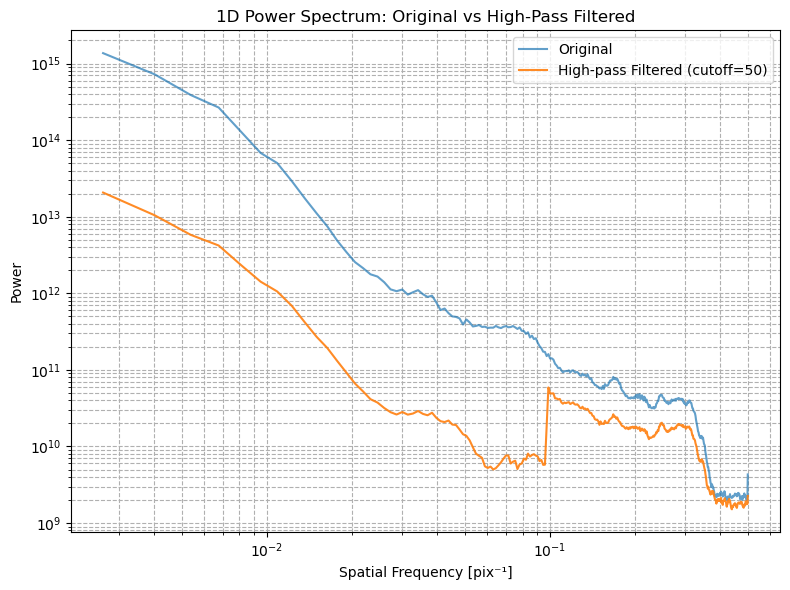

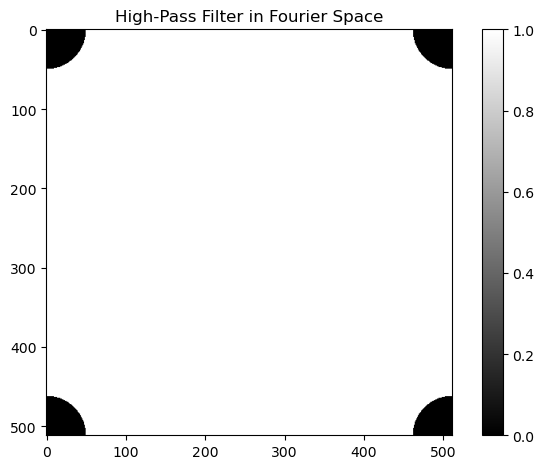

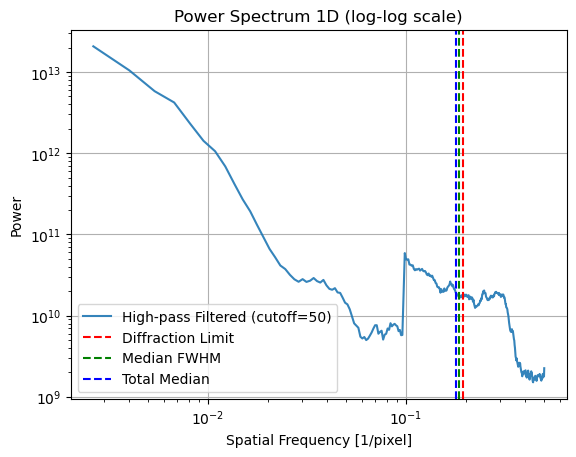

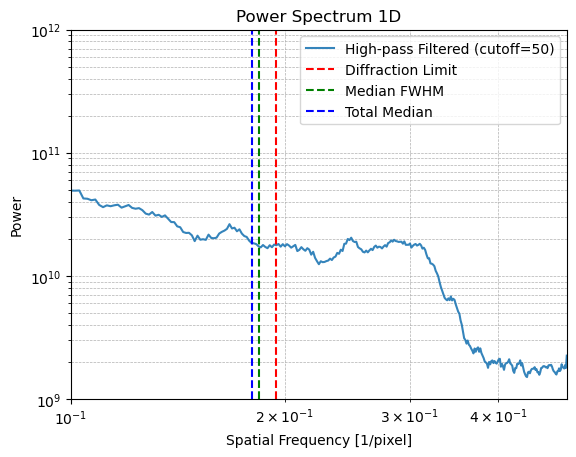

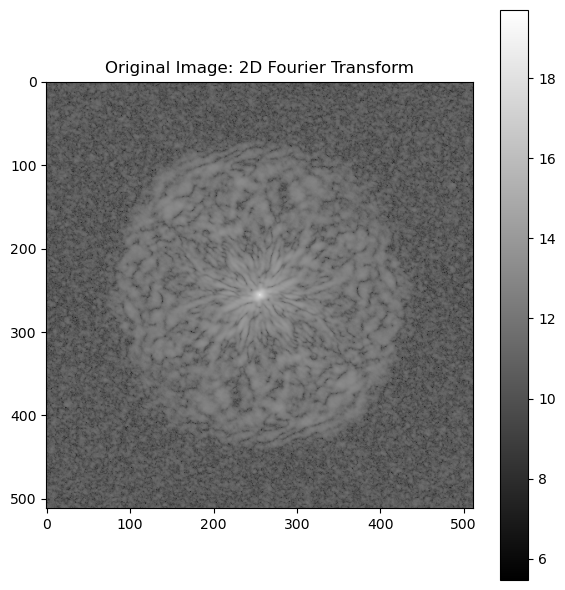

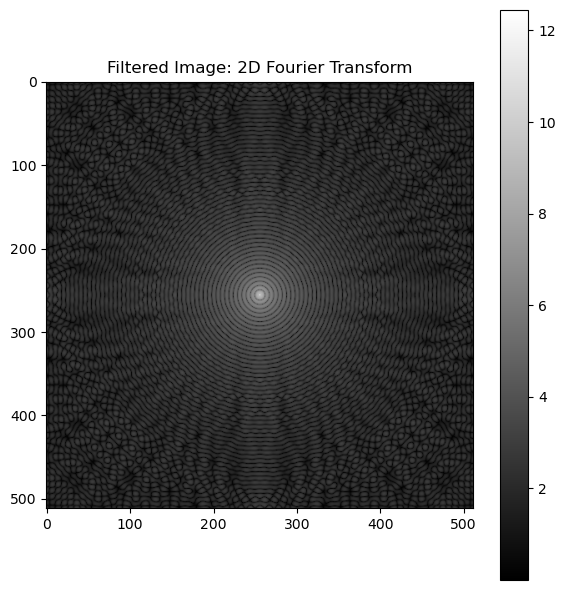

Highpass filtered image saved to outputs/highpass_filtered_image_NOCLEAN.fits


In [ ]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from astropy.io import fits
import matplotlib.pyplot as plt

#######################################################################################à
# high-pass filter
def create_highpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.ones(shape, dtype=np.float32)
    mask[radius_squared < cutoff**2] = 0
    return fftshift(mask)

def create_lowpass_filter(shape, cutoff_low):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius_squared = (x - ccol)**2 + (y - crow)**2
    mask = np.zeros(shape, dtype=np.float32)
    mask[radius_squared < cutoff_low**2] = 1
    return fftshift(mask)

# high-pass filter application
def fourier_highpass_filter(image, cutoff):
    F_image = fft2(image)
    hp_filter = create_highpass_filter(image.shape, cutoff)
    F_filtered = F_image * hp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, hp_filter

# low-pass filter application
def fourier_lowpass_filter(image, cutoff_low):
    F_image = fft2(image)
    lp_filter = create_lowpass_filter(image.shape, cutoff_low)
    F_filtered = F_image * lp_filter
    filtered_image = ifft2(F_filtered).real
    return filtered_image, lp_filter

#####################################################################################################
###############################################################################################à
imagenumber = 500  
stacked = False
if stacked == True:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)  # Sum of  images
    background_level = np.median(data)
    data = data - background_level
    data[data < 0] = 0
    image = data.copy()
else:
    data = immagini[imagenumber]
    #data_raw = data.copy()
    #background_level = np.median(data_raw)
    #data = data_raw - background_level
    #data[data < 0] = 0
    image = data.copy()
#################################################################################################à
# --------------------------------------------
# APPLY FOURIER-SPACE HIGH-PASS FILTER
#image = np.asarray(Image.open('immagini\prova_fft.png'))

cutoff = 50  # Radius in pixels for cutoff frequency
cutoff_low = 200
highpass, hp_filter = fourier_highpass_filter(image, cutoff=cutoff)
lowpass, lp_filter = fourier_lowpass_filter(image, cutoff_low=cutoff_low)

# Check for NaNs or Infs in the filtered image
if np.any(np.isnan(highpass)) or np.any(np.isinf(highpass)):
    print("Warning: NaN or Inf values found in the filtered image!")

# Clip any negative values to zero
highpass = np.maximum(highpass, 0)
lowpass = np.maximum(lowpass, 0)

# Clean filtered images
highpass = np.nan_to_num(highpass)
lowpass = np.nan_to_num(lowpass)

#POWER SPECTRA
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0
pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)


#PLOTS
plt.figure(figsize=(8, 6))
plt.plot(pspec_raw.freqs.value, pspec_raw.ps1D, label='Original', alpha=0.7)
plt.plot(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Spatial Frequency [pix⁻¹]")
plt.ylabel("Power")
plt.title("1D Power Spectrum: Original vs High-Pass Filtered")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# FILTER PLOT
plt.figure()
plt.imshow(hp_filter, cmap='gray')
plt.title("High-Pass Filter in Fourier Space")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.title('Power Spectrum 1D (log-log scale)')
plt.grid(True)
plt.legend()
plt.show()

plt.loglog(pspec_filtered.freqs.value, pspec_filtered.ps1D, label=f'High-pass Filtered (cutoff={cutoff})', alpha=0.9)
plt.axvline(x=1/(diffraction_limit_arcseconds/plate_scale), color='r', linestyle='--', label='Diffraction Limit')
plt.axvline(x=1/(0.204/plate_scale), color='g', linestyle='--', label='Median FWHM')
plt.axvline(x=1/(0.209/plate_scale), color='blue', linestyle='--', label='Total Median')
plt.xlim(0.1, pspec_filtered.freqs.value.max())
plt.xlim(0.1, pspec_filtered.freqs.value.max())
plt.ylim(1e9, 1e12)
plt.xlabel('Spatial Frequency [1/pixel]')
plt.ylabel('Power')
plt.title('Power Spectrum 1D')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

def plot_fourier_transform(image, title="2D Fourier Transform"):
    F_image = fft2(image) 
    F_image_shifted = fftshift(F_image)  
    magnitude = np.abs(F_image_shifted)  
    
    plt.figure(figsize=(6, 6))
    plt.imshow(np.log(magnitude + 1), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_fourier_transform(image, title="Original Image: 2D Fourier Transform")
plot_fourier_transform(hp_filter, title="Filtered Image: 2D Fourier Transform")
def plot_mask_with_circle(mask, cutoff, title="Mask with Circle"):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Save the highpass filtered image as a FITS file
output_path = "outputs/highpass_filtered_image_NOCLEAN.fits"
fits.writeto(output_path, highpass, overwrite=True)
print(f"Highpass filtered image saved to {output_path}")



## Gaussian Filter

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


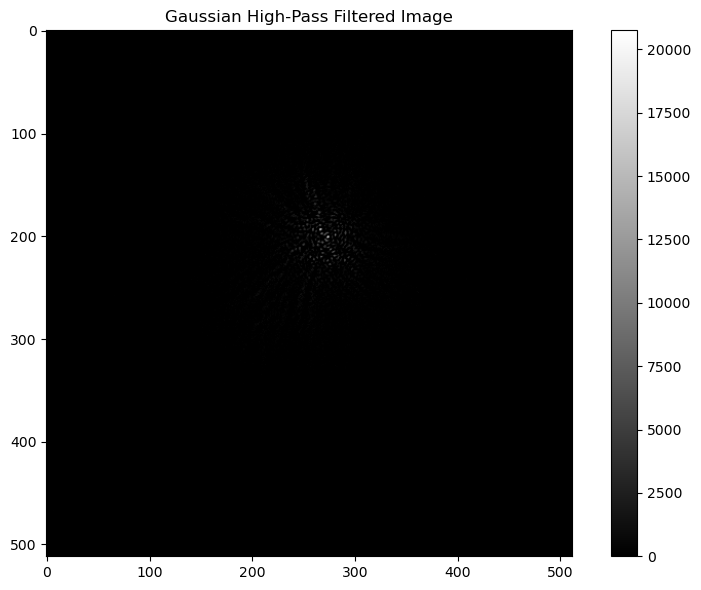

In [63]:
import numpy as np
from astropy.io.fits import Header
import astropy.units as u
from turbustat.statistics import PowerSpectrum
from scipy.fft import fft2, ifft2, fftshift, fftfreq
import matplotlib.pyplot as plt

# --------------------------------------------
# Gaussian High-Pass Filter (Frequency Domain)
def gaussian_highpass_filter(image, sigma):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.ogrid[:rows, :cols]
    distance_squared = (x - ccol)**2 + (y - crow)**2

    # Create Gaussian low-pass mask, then invert to get high-pass
    gaussian_lp = np.exp(-distance_squared / (2 * sigma**2))
    gaussian_hp = 1 - gaussian_lp

    # Apply in frequency domain
    F_image = fft2(image)
    F_filtered = F_image * fftshift(gaussian_hp)
    filtered_image = np.real(ifft2(F_filtered))

    return filtered_image, gaussian_hp

# --------------------------------------------
# Load and prepare image
imagenumber = 500  
stacked = False  # Set to True to stack images

if stacked:
    data = np.sum(immagini[imagenumber:imagenumber + 3], axis=0)
else:
    data = immagini[imagenumber]

background_level = np.median(data)
data = data - background_level
data[data < 0] = 0
image = data.copy()

# --------------------------------------------
# Apply Gaussian High-Pass Filter
sigma = 50  # Controls frequency cutoff sharpness higher = more tolerant
highpass, hp_filter = gaussian_highpass_filter(image, sigma=sigma)

# Clean filtered image
highpass = np.nan_to_num(np.maximum(highpass, 0))

# --------------------------------------------
# Power Spectrum Calculation
header = Header()
header['CDELT1'] = 1.0
header['CDELT2'] = 1.0

pspec_raw = PowerSpectrum(image, header=header, distance=1 * u.pc)
pspec_raw.run(verbose=False, xunit=u.pix**-1)

pspec_filtered = PowerSpectrum(highpass, header=header, distance=1 * u.pc)
pspec_filtered.run(verbose=False, xunit=u.pix**-1)

# --------------------------------------------
# Plot Power Spectra
plt.figure(figsize=(8, 6))
plt.imshow(highpass, cmap='gray')
plt.title("Gaussian High-Pass Filtered Image")
plt.colorbar()
plt.tight_layout()
plt.show()
